In [42]:
from __future__ import print_function
import time
import upstox_client
from upstox_client.rest import ApiException
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

STEP 1:

In [43]:
api_instance = upstox_client.HistoryApi()
instrument_key = 'NSE_EQ|INE040H01021'  # Suzlon Energy
interval = 'day'
from_date = '2020-01-01'
to_date = '2023-01-31'
api_version = '3.0'

In [44]:
try:
    api_response = api_instance.get_historical_candle_data1(instrument_key, interval, to_date, from_date, api_version)
except ApiException as e:
    print("Exception when calling HistoryApi->get_historical_candle_data1: %s\n" % e)
    exit()

STEP 2:

In [45]:
def parse_historical_data(api_response):
    if api_response.status == 'success' and hasattr(api_response, 'data') and 'candles' in api_response.data:
        candles = api_response.data['candles']
        if not candles:
            print("Error: No candles returned in API response")
            return None
        # Quick fix: Reverse candles to ensure earliest date first
        candles = candles[::-1]
        df = pd.DataFrame(candles, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'oi'])
        try:
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            if df['date'].isna().any():
                print("Error: Some dates could not be parsed to datetime")
                return None
        except Exception as e:
            print(f"Error parsing dates: {e}")
            return None
        df.set_index('date', inplace=True)
        df = df.sort_index(ascending=True)
        print(f"DataFrame date range: {df.index.min()} to {df.index.max()}")
        days = (df.index.max() - df.index.min()).days if not df.index.empty else 0
        print(f"Number of days: {days}")
        if days <= 0:
            print("Error: Invalid date range (end date not after start date)")
            return None
        try:
            df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
        except Exception as e:
            print(f"Error converting columns to float: {e}")
            return None
        return df
    else:
        print("No data returned from API or invalid response structure")
        return None

In [46]:
# Access the data from the API response object
if hasattr(api_response, 'data') and hasattr(api_response.data, 'candles'):
    candles = api_response.data.candles
    if not candles:
        print("Error: No candles returned in API response")
        exit()
    
    # Reverse candles to ensure earliest date first
    candles = candles[::-1]
    df = pd.DataFrame(candles, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'oi'])
    
    try:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if df['date'].isna().any():
            print("Error: Some dates could not be parsed to datetime")
            exit()
    except Exception as e:
        print(f"Error parsing dates: {e}")
        exit()
    
    df.set_index('date', inplace=True)
    df = df.sort_index(ascending=True)
    print(f"DataFrame date range: {df.index.min()} to {df.index.max()}")
    
    # Convert numeric columns to float
    try:
        df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    except Exception as e:
        print(f"Error converting columns to float: {e}")
        exit()
        
    print("Historical data processed successfully")
    print(df.head())
else:
    print("No data returned from API or invalid response structure")
    exit()

DataFrame date range: 2020-01-01 00:00:00+05:30 to 2023-01-31 00:00:00+05:30
Historical data processed successfully
                           open  high   low  close       volume  oi
date                                                               
2020-01-01 00:00:00+05:30  1.70  1.80  1.70   1.75    7775938.0   0
2020-01-02 00:00:00+05:30  1.75  2.05  1.75   2.05   28551109.0   0
2020-01-03 00:00:00+05:30  2.50  2.50  2.30   2.50  133226268.0   0
2020-01-06 00:00:00+05:30  2.70  2.95  2.50   2.95  155057335.0   0
2020-01-07 00:00:00+05:30  3.15  3.20  3.15   3.20   11822151.0   0


STEP 3:

In [47]:
def calculate_kama(close, er_period=10, fast_period=2, slow_period=15):
    close = pd.Series(close, dtype=float)
    abs_diff = close.diff().abs()
    volatility = abs_diff.rolling(er_period).sum()
    direction = close - close.shift(er_period)
    er = direction.abs() / volatility
    er = er.fillna(0)
    alpha_fast = 2 / (fast_period + 1)
    alpha_slow = 2 / (slow_period + 1)
    sc = (er * (alpha_fast - alpha_slow) + alpha_slow) ** 2
    kama = pd.Series(np.nan, index=close.index)
    for t in range(er_period, len(close)):
        if t == er_period:
            kama.iloc[t] = close.iloc[t]
        else:
            kama.iloc[t] = kama.iloc[t-1] + sc.iloc[t] * (close.iloc[t] - kama.iloc[t-1])
    return kama

In [48]:
df['kama'] = calculate_kama(df['close'], er_period=8, fast_period=2, slow_period=30)

STEP 4:

In [49]:
def generate_signals(close, kama, sma10):
    signals = pd.Series(0, index=close.index, dtype=int)
    position = 0
    for t in range(1, len(close)):
        if pd.isna(kama.iloc[t-1]) or pd.isna(kama.iloc[t]) or pd.isna(sma10.iloc[t]):
            continue
        if position == 0:
            if (close.iloc[t] > kama.iloc[t] and 
                close.iloc[t-1] <= kama.iloc[t-1] and 
                close.iloc[t] > sma10.iloc[t]):
                signals.iloc[t] = 1
                position = 1
        elif position == 1:
            if close.iloc[t] < kama.iloc[t] or close.iloc[t] < sma10.iloc[t]:
                signals.iloc[t] = -1
                position = 0
    return signals

In [50]:
df['sma10'] = df['close'].rolling(10).mean()
df['signal'] = generate_signals(df['close'], df['kama'], df['sma10'])

STEP 5:

In [51]:
def backtest_strategy(df, signals, initial_capital=100000, stop_loss_pct=0.05):
    cash = initial_capital
    position = 0
    equity = []
    entry_price = None
    trades = []
    
    for t in range(len(df)):
        close_price = df['close'].iloc[t]
        signal = signals.iloc[t]
        if position > 0 and close_price < entry_price * (1 - stop_loss_pct):
            cash += position * close_price
            trades.append({
                'entry_date': df.index[t-1],
                'exit_date': df.index[t],
                'entry_price': entry_price,
                'exit_price': close_price,
                'profit': (close_price - entry_price) * position
            })
            position = 0
            entry_price = None
        elif signal == 1 and position == 0:
            shares = int(cash // close_price)
            if shares > 0:
                cash -= shares * close_price
                position = shares
                entry_price = close_price
        elif signal == -1 and position > 0:
            cash += position * close_price
            trades.append({
                'entry_date': df.index[t-1],
                'exit_date': df.index[t],
                'entry_price': entry_price,
                'exit_price': close_price,
                'profit': (close_price - entry_price) * position
            })
            position = 0
            entry_price = None
        total = cash + position * close_price if position > 0 else cash
        equity.append(total)
    
    equity = pd.Series(equity, index=df.index)
    final_value = equity.iloc[-1]
    total_return = ((final_value / initial_capital) - 1) * 100
    days = (df.index[-1] - df.index[0]).days
    print(f"Debug - Number of days: {days}")
    years = days / 365.25
    print(f"Debug - Years: {years}")
    cagr = ((final_value / initial_capital) ** (1 / years) - 1) * 100 if years > 0 else 0
    rolling_max = equity.cummax()
    drawdowns = (rolling_max - equity) / rolling_max * 100
    max_drawdown = drawdowns.max()
    
    if trades:
        profits = [trade['profit'] for trade in trades]
        wins = [p for p in profits if p > 0]
        losses = [abs(p) for p in profits if p < 0]
        avg_win = np.mean(wins) if wins else 0
        avg_loss = np.mean(losses) if losses else 0
        risk_reward = 1 / (avg_win / avg_loss) if avg_loss != 0 else float('inf')
    else:
        risk_reward = 0
    
    return {
        'total_return': total_return,
        'cagr': cagr,
        'max_drawdown': max_drawdown,
        'risk_reward_ratio': risk_reward,
        'equity': equity
    }

In [52]:
# Run backtest
results = backtest_strategy(df, df['signal'], stop_loss_pct=0.05)
print(f"Total Return: {results['total_return']:.2f}%")
print(f"CAGR: {results['cagr']:.2f}%")
print(f"Maximum Drawdown: {results['max_drawdown']:.2f}%")
print(f"Risk-Reward Ratio: {results['risk_reward_ratio']:.2f}" if results['risk_reward_ratio'] != float('inf') else "Risk-Reward Ratio: inf (no losing trades)")

Debug - Number of days: 1126
Debug - Years: 3.082819986310746
Total Return: 532.94%
CAGR: 81.95%
Maximum Drawdown: 23.91%
Risk-Reward Ratio: 0.27


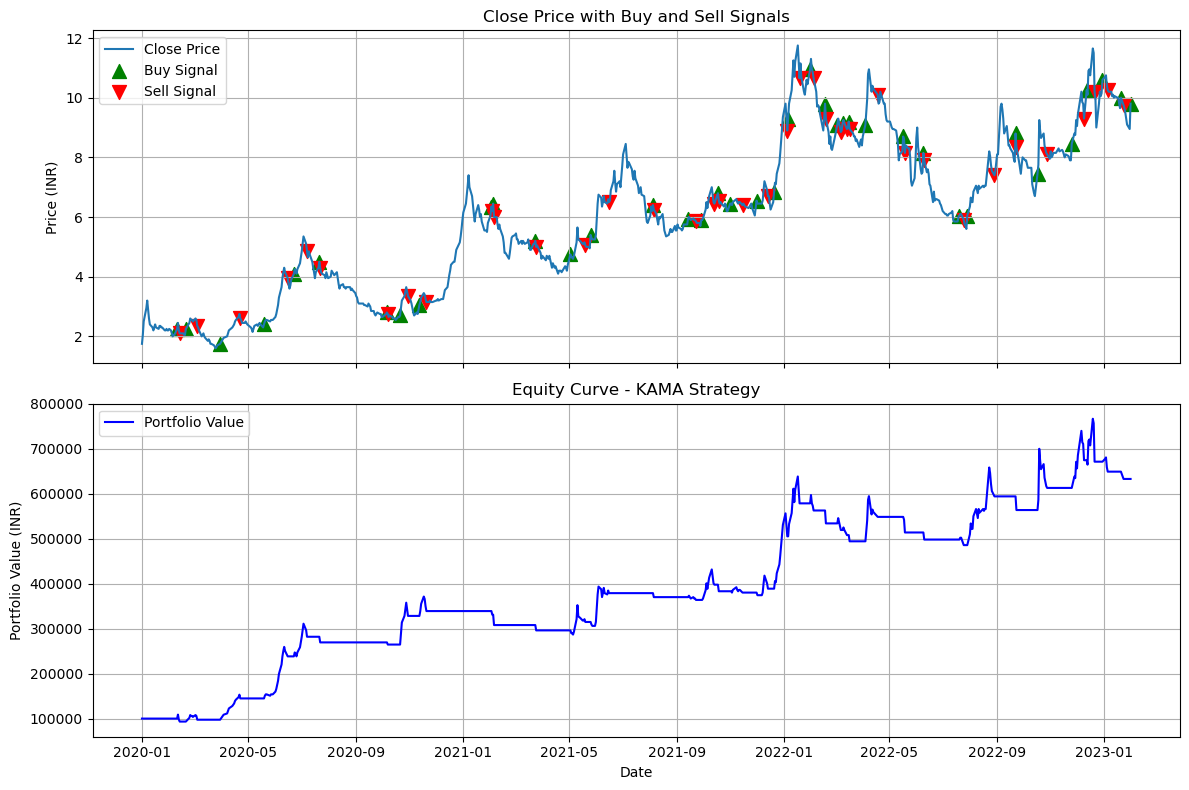

In [53]:
def plot_results(df, equity):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    ax1.plot(df.index, df['close'], label='Close Price')
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    ax1.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal', s=100)
    ax1.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal', s=100)
    ax1.set_title('Close Price with Buy and Sell Signals')
    ax1.set_ylabel('Price (INR)')
    ax1.legend()
    ax1.grid()
    ax2.plot(equity, label='Portfolio Value', color='b')
    ax2.set_title('Equity Curve - KAMA Strategy')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Portfolio Value (INR)')
    ax2.legend()
    ax2.grid()
    plt.tight_layout()
    plt.show()

plot_results(df, results['equity'])